In [19]:
import os
import cv2 as cv
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import imblearn
from tabulate import tabulate
from keras.optimizers import Adam

print(tf.__version__)
print('okkk')

2.9.1
okkk


In [20]:
train_dir = 'C:\OPPO\Intern5\Train'
test_dir = 'C:\OPPO\Intern5\Test'
val_dir = 'C:\OPPO\Intern5\Val'
batch_size = 32
img_size = (32, 32)

import pathlib
img_train_dir = pathlib.Path(train_dir)
img_test_dir = pathlib.Path(test_dir)
img_val_dir = pathlib.Path(val_dir)
img_train_cnt = len(list(img_train_dir.glob('*/*.png')))
img_test_cnt = len(list(img_test_dir.glob('*/*.png')))
img_val_cnt = len(list(img_val_dir.glob('*/*.png')))
print(img_train_cnt, img_test_cnt, img_val_cnt)

print('Total Images in Train:', img_train_cnt)
print('Total Images in Test:', img_test_cnt)
print('Total Images in Val:', img_val_cnt)

10115 6810 2310
Total Images in Train: 10115
Total Images in Test: 6810
Total Images in Val: 2310


In [21]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  image_size=img_size,
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  image_size=img_size,
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 10115 files belonging to 5 classes.
Found 2310 files belonging to 5 classes.
['No vehicles', 'Others', 'Road narrows on the right', 'Speed limit (30km_h)', 'Speed limit (70km_h)']


(32, 32, 32, 3)
(32,)


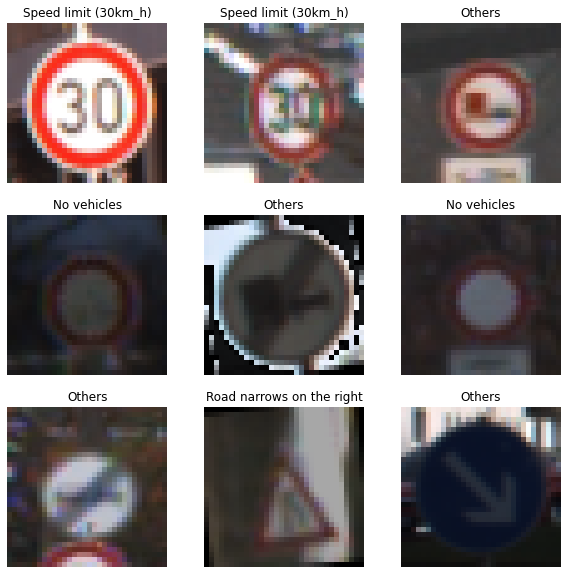

In [22]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(5):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in train_ds.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)
  ##break

In [23]:
normalization_layer = layers.Rescaling(1./255)
print("Normalization layer is created")

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
print("This layer is applied to dataset using map function")

image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in [0,1].
print(np.min(first_image), np.max(first_image))

print(class_names)
num_classes = len(class_names)
print(num_classes)

Normalization layer is created
This layer is applied to dataset using map function
0.0 0.56078434
['No vehicles', 'Others', 'Road narrows on the right', 'Speed limit (30km_h)', 'Speed limit (70km_h)']
5


In [24]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_size[0], img_size[1], 3)),
    
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

opt = Adam(learning_rate = 0.0001)
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 64)         

In [25]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

path_to_save = os.path.join(os.getcwd(), 'Models')
model.save(path_to_save)

model = keras.models.load_model(path_to_save)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

Epoch 1/20
317/317 [==============================] - 10s 30ms/step - loss: 1.4127 - accuracy: 0.4207 - val_loss: 1.5073 - val_accuracy: 0.4277
Epoch 2/20
317/317 [==============================] - 9s 28ms/step - loss: 0.8755 - accuracy: 0.7162 - val_loss: 1.3328 - val_accuracy: 0.4918
Epoch 3/20
317/317 [==============================] - 10s 32ms/step - loss: 0.6408 - accuracy: 0.7993 - val_loss: 1.0778 - val_accuracy: 0.5965
Epoch 4/20
317/317 [==============================] - 11s 34ms/step - loss: 0.5182 - accuracy: 0.8464 - val_loss: 0.8867 - val_accuracy: 0.6814
Epoch 5/20
317/317 [==============================] - 11s 35ms/step - loss: 0.4336 - accuracy: 0.8796 - val_loss: 0.7248 - val_accuracy: 0.7489
Epoch 6/20
317/317 [==============================] - 10s 32ms/step - loss: 0.3696 - accuracy: 0.8960 - val_loss: 0.5177 - val_accuracy: 0.8325
Epoch 7/20
317/317 [==============================] - 11s 34ms/step - loss: 0.3127 - accuracy: 0.9144 - val_loss: 0.6163 - val_accuracy: 

INFO:tensorflow:Assets written to: C:\Users\605246\OPPO\Models\assets


INFO:tensorflow:Assets written to: C:\Users\605246\OPPO\Models\assets


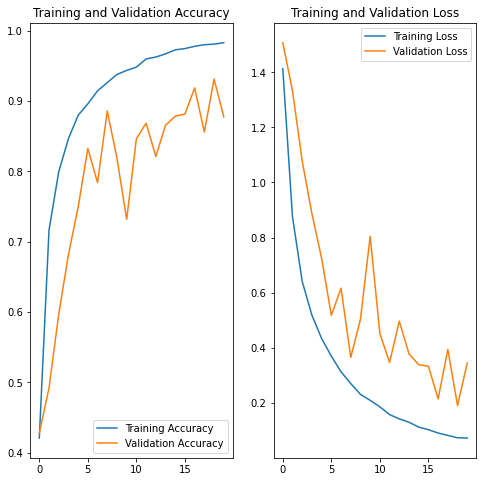

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,

  image_size=img_size,
  batch_size=batch_size)

results = model.evaluate(test_ds,batch_size=32)
print(results)

Found 6810 files belonging to 5 classes.


C:\Users\605246\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


213/213 [==============================] - 3s 13ms/step - loss: 0.4764 - accuracy: 0.8546
[0.4763690233230591, 0.8546255230903625]


In [28]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  plt.figure(figsize=(10, 10))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)

  plt.title(title)
  plt.colorbar()

  tick_marks = np.arange(len(classes))

  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [29]:
target_names = []
class_names = train_ds.class_names
print(class_names)
for key in train_ds.class_names:
    target_names.append(key)

print(target_names)

y= np.concatenate([y for x,y in test_ds],axis=0)
Y_pred = model.predict(test_ds)
y_pred = np.argmax(Y_pred, axis=1)

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:  # use dataset.unbatch() with repeat
  # append true labels
  y_true.append(label_batch)
  # compute predictions
  preds = model.predict(image_batch)
  # append predicted labels
  y_pred.append(np.argmax(preds, axis=- 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis=0)
predicted_labels = tf.concat([item for item in y_pred], axis=0)

cm = tf.math.confusion_matrix(
  correct_labels,
  predicted_labels,
  num_classes=5,
  weights=None,
  dtype=tf.dtypes.int32, )
print('Confusion matrix:')
print(cm)
matrix = classification_report(correct_labels, predicted_labels, target_names=class_names)
print('Classification report : \n', matrix)

['No vehicles', 'Others', 'Road narrows on the right', 'Speed limit (30km_h)', 'Speed limit (70km_h)']
['No vehicles', 'Others', 'Road narrows on the right', 'Speed limit (30km_h)', 'Speed limit (70km_h)']
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 119ms/step
Confusion matrix:
tf.Tensor(
[[ 206    0    0    0    4]
 [  23 4264  174  367  302]
 [   0    9   78    1    2]
 [   0    5    0  714    1]
 [   0   46    1   55  558]], shape=(5, 5), dtype=int32)
Classification report : 
                            precision    recall  f1-score   support

              No vehicles       0.90      0.98      0.94       210
                   Others       0.99      0.83      0.90      5130
Road narrows on the right       0.31      0.87      0.45        90
     Speed limit (30km_h)       0.63      0.99      0.77       720
     Speed limit (70km_h)       0.64      0.85      0.73       660

                 accuracy                           0.85      6810
                macro avg       0.69      0.90      0.76      6810
             weighted avg       0.90      0.85      0.87      6810

